<a href="https://colab.research.google.com/github/romanescobar/Challenge-Telecom-X/blob/main/notebooks/FlightOnTime_Modelado%202.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANÁLISIS DE DATOS (EDA)

### IMPORTAR LIBRERIAS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### CARGA DE DATOS

In [ ]:
# DATASET
# Airline:  aerolínea
# Flight:   tipo de aeronave
# Time:     hora de salida en minutos (desde medianoche)
# Length:   tiempo de vuelo en minutos
url = 'https://raw.githubusercontent.com/Sts87/FlightOnTime/refs/heads/main/data/Airlines.csv'
df = pd.read_csv(url)

# Referencia Dataset: https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay

### FUNCIONES

In [ ]:
def ancho_bin(df, columna):
    q1, q3 = np.percentile(df[columna], [25, 75])
    iqr = q3 - q1
    ancho = 2 * iqr * np.power(len(df[columna]), -1/3)
    return ancho

### INSPECCIÓN INICIAL

In [ ]:
# VISUALIZAR COLUMNAS Y DATOS DE DATASET ORIGINAL
# -Cada fila representa un vuelo
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [ ]:
# ESTRUCTURA DEL DATASET
# -Vuelos: 539k
# -Campos: 9
df.shape

(539383, 9)

In [ ]:
# PROPIEDADES DE LOS CAMPOS
# -Los tipos de datos están correctamente asignados (enteros, cadenas)
# -No existen nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Length       539383 non-null  int64 
 8   Delay        539383 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 37.0+ MB


### LIMPIEZA DE DATOS

In [ ]:
# ELIMINAR COLUMNA ID
# -No es necesario tener el identificador único en el dataset
df.drop('id', axis=1, inplace=True)

In [ ]:
# VALIDAR VALORES EN BLANCO
# -No se encontraron columnas con valores vacios
(df == '').sum()

,0
Airline,0
Flight,0
AirportFrom,0
AirportTo,0
DayOfWeek,0
Time,0
Length,0
Delay,0


### ANÁLISIS ESTADÍSTICO

In [ ]:
# VARIABLES NÚMERICAS
# -Las variables Time y Length tienen comportamiento normal aparentemente
df[['Time', 'Length']].describe().round(1)

,Time,Length
count,539383.0,539383.0
mean,802.7,132.2
std,278.0,70.1
min,10.0,0.0
25%,565.0,81.0
50%,795.0,115.0
75%,1035.0,162.0
max,1439.0,655.0


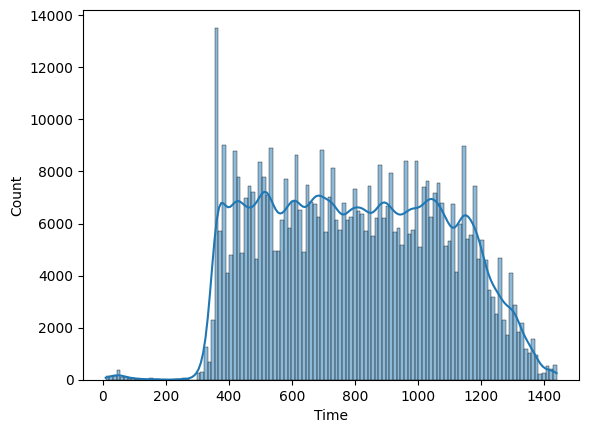

In [ ]:
# Time
# -Tiene un rango con distribucion que se asemeja a uniforme desde 400 hasta 1000
#   -Esto indica que los horarios de salida tiene frecuencia similar en este rango
# -Existen outliers significativos en los valores superiores de la distribución
anchobin = ancho_bin(df, 'Time')
sns.histplot(data=df, x='Time', kde=True, binwidth=anchobin)
plt.show()

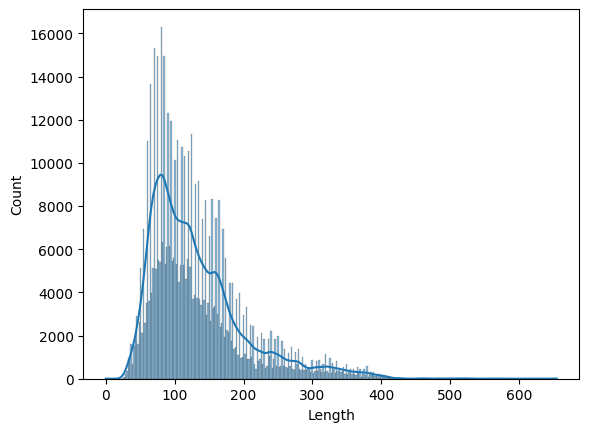

In [ ]:
# Length
# -Tiene distribucion que se asemeja a una normal
# -Esto indica que la duración de vuelo está concentrada en el rango de 50 - 180 minutos
anchobin = ancho_bin(df, 'Length')
sns.histplot(data=df, x='Length', kde=True, binwidth=anchobin)
plt.show()

In [ ]:
# VARIABLES CATEGÓRICAS
# -La variable Airline tiene 18 clases, lo cual indica que está atomizada
# -Las variables AirportFrom y AirportTo tienen 293, están muy atomizadas
df.describe(include='object')

,Airline,AirportFrom,AirportTo
count,539383,539383,539383
unique,18,293,293
top,WN,ATL,ATL
freq,94097,34449,34440


### PROPORCIÓN DE CLASES DE LA VARIABLE OBJETIVO

In [ ]:
# IDENTIFICAR SI HAY DESBALANCEO EN LA VARIABLES OBJETIVO (DELAY)
# -No hay desbalanceo: proporcion 55-45%
df_cnt = df['Delay'].value_counts()
df_pct = df['Delay'].value_counts(normalize=True).round(2) * 100

df_delay = pd.concat([df_cnt, df_pct], axis=1)
df_delay

,count,proportion
Delay,,
0,299119,55.0
1,240264,45.0


### NUEVAS VARIABLES

In [ ]:
# NUEVAS VARIABLES CANDIDATAS
# Hour: Hora en formato hh:mm
df['DateHour'] = df['Time'].apply(lambda x: str(x // 60).zfill(2) + ":" + str(x % 60).zfill(2))
df['DateHour'] = pd.to_datetime(df['DateHour'], format="%H:%M")

# Hour: Hora en formato decimal
df['Hour'] = df['Time'] / 60

# Time of day: Momento del dia de la salida del vuelo
# -Early morning: [0AM  - 6AM]
# -Morning:       <6AM  - 12PM]
# -Early morning: <12PM - 6PM]
# -Early morning: <6PM  - 12AM>
clases = [0, 360, 720, 1080, 1440]
labels = ['Early morning', 'Morning', 'Afternoon', 'Night']
df['TimeDay'] = pd.cut(x=df['Time'], bins=clases, labels=labels, include_lowest=True)

# Duration: Duracion del vuelo
# -Short:  [0min   - 90min]
# -Medium: <90min  - 180min]
# -Long:   [180min - 960min]
clases = [0, 90, 180, 960]
labels = ['Short', 'Medium', 'Long']
df['Duration'] = pd.cut(x=df['Length'], bins=clases, labels=labels, include_lowest=True)

### ANALISIS DESCRIPTIVO

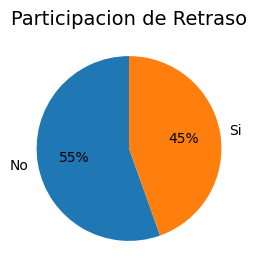

In [ ]:
# FRECUENCIA DE TARGET
# -A tiempo 55%
# -Retraso 45%
plt.figure(figsize=(4, 3))
plt.pie(df['Delay'].value_counts(), labels=['No','Si'], autopct='%1.0f%%', startangle=90)
plt.title('Participacion de Retraso', fontsize=14)
plt.show()

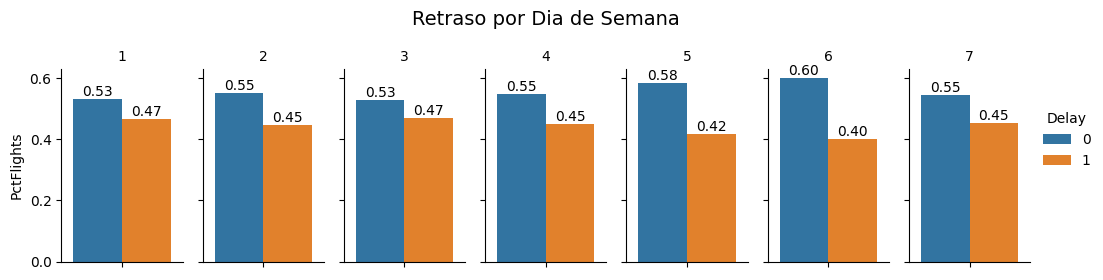

In [ ]:
# RETRASO POR DÍA Y SEMANA
# -Los días 1,2,3,4,7 tienen una proporción de retrasos del 45% aprox.
# -Los dias 5 y 6 tienen menores retrasos, con 40% aprox.
df2 = df.groupby(['DayOfWeek', 'Delay'])['Delay'].count().reset_index(name='NumFlights')
df2['PctFlights'] = df2.groupby('DayOfWeek')['NumFlights'].transform(lambda x: x / x.sum())

g = sns.catplot(
       data=df2, hue="Delay", y="PctFlights", col="DayOfWeek",
       kind="bar", height=2.5, aspect=.6
    )

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge')

g.set_titles(col_template="{col_name}", fontdict={'fontsize': 11})
g.fig.suptitle("Retraso por Dia de Semana", y=1.1, fontsize=14)

plt.show()

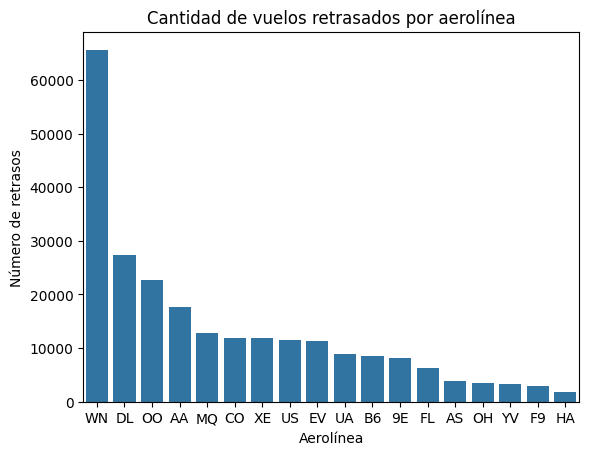

In [ ]:
# CANTIDAD DE VUELOS RETRASADOS POR AEROLINEA
# -La aerolínea WN tiene mas de 60k retrasos, más del doble de la siguiente aerolínea
# -Se debe verificar en términos relativos si este retraso es significativo, así como el de otras aerolíneas
order = (
    df[df['Delay']==1].groupby('Airline').size().sort_values(ascending=False).index
)

sns.countplot(data= df[df['Delay']==1], x='Airline', order=order)
plt.title("Cantidad de vuelos retrasados por aerolínea")
plt.xlabel("Aerolínea")
plt.ylabel("Número de retrasos")
plt.show()

In [ ]:
df2.sample(2)

,DayOfWeek,Delay,NumFlights,PctFlights
8,5,0,49733,0.583392
4,3,0,47492,0.529182


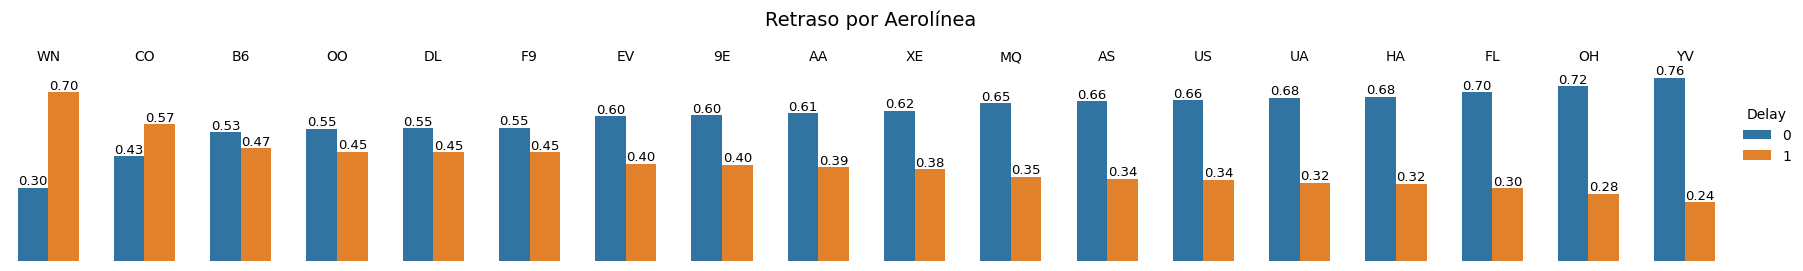

In [ ]:
# RETRASO POR AEROLÍNEA
# -Sólo WN y CO tienen mayor proporcion de retrasos (0.7, 0.57)
df2 = df.groupby(['Airline', 'Delay'])['Delay'].count().reset_index(name='NumFlights')
df2['PctFlights'] = df2.groupby('Airline')['NumFlights'].transform(lambda x: x / x.sum())

g = sns.catplot(
       data=df2.sort_values(['Delay', 'PctFlights'], ascending=[False, False]),
       hue="Delay", y="PctFlights", col="Airline",
       kind="bar", height=2.5, aspect=.4
    )

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9.5)

g.set(ylabel=None)
g.set(yticklabels=[])
g.tick_params(left=False, bottom=False)
g.despine(left=True, bottom=True)

g.set_titles(col_template="{col_name}", fontdict={'fontsize': 10.5})
g.fig.suptitle("Retraso por Aerolínea", y=1.1, fontsize=14)

plt.show()

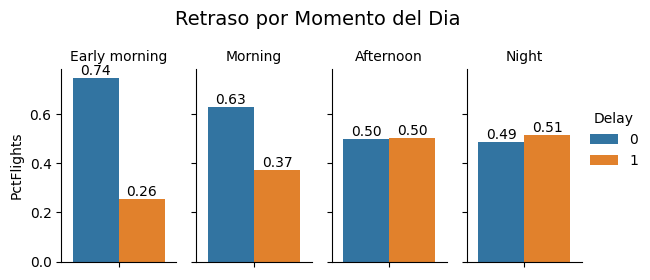

In [ ]:
# RETRASO POR MOMENTO DEL DÍA
# -Los retrasos tienen una alta proporcion (~50%) en la tarde y noche
df2 = df.groupby(['TimeDay', 'Delay'], observed=True)['Delay'].count().reset_index(name='NumFlights')
df2['PctFlights'] = df2.groupby('TimeDay', observed=True)['NumFlights'].transform(lambda x: x / x.sum())

g = sns.catplot(
       data=df2, hue="Delay", y="PctFlights", col="TimeDay",
       kind="bar", height=2.5, aspect=.6
    )

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge')


g.set_titles(col_template="{col_name}", fontdict={'fontsize': 11})
g.fig.suptitle("Retraso por Momento del Dia", y=1.1, fontsize=14)

plt.show()

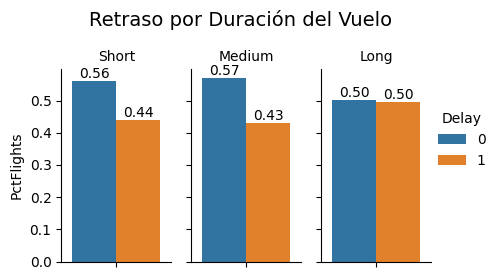

In [ ]:
# RETRASO POR DURACIÓN DE VUELO
# -Los retrasos tienen una alta proporcion en los vuelos largos (~50%)
df2 = df.groupby(['Duration', 'Delay'], observed=True)['Delay'].count().reset_index(name='NumFlights')
df2['PctFlights'] = df2.groupby('Duration', observed=True)['NumFlights'].transform(lambda x: x / x.sum())

g = sns.catplot(
       data=df2, hue="Delay", y="PctFlights", col="Duration",
       kind="bar", height=2.5, aspect=.6
    )

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge')


g.set_titles(col_template="{col_name}", fontdict={'fontsize': 11})
g.fig.suptitle("Retraso por Duración del Vuelo", y=1.1, fontsize=14)

plt.show()

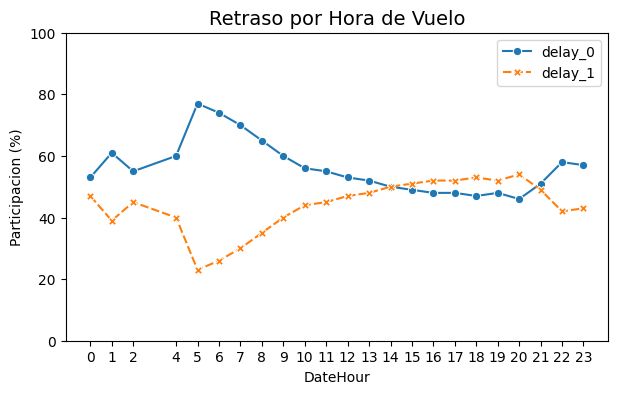

In [ ]:
# RETRASO POR HORA DE VUELO
# -Se observa una tendencia creciente a medida que pasa el dia: desde las 5 hasta las 20 horas
df2 = pd.crosstab(df['DateHour'].dt.hour, df['Delay'], normalize='index').round(2) * 100
df2.columns = ['delay_0', 'delay_1']

ax = sns.lineplot(data=df2, markers=True)

ax.set_xticks(df2.index, labels=df2.index)
ax.set_yticks(range(0, 101, 20))
ax.set_ylabel("Participacion (%)")
ax.set_title("Retraso por Hora de Vuelo", fontsize=14, fontweight='normal')
ax.figure.set_size_inches(7, 4)

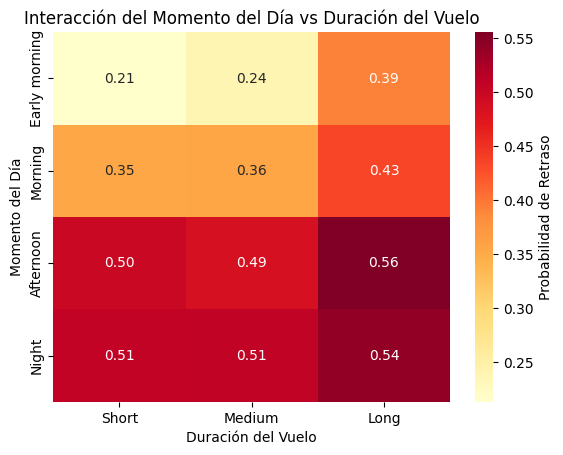

In [ ]:
# ANÁLISIS MOMENTO DEL DÍA VS. DURACIÓN
# -Se observa que para todos los vuelos por duración, la probabilidad de retraso aumenta a medida que transcurre el día
# -Los vuelos largos tienen mayor probabilidad de retraso comparativamente con otros tipos de vuelos
timeday_duration = df.pivot_table(
    index='TimeDay', columns='Duration', values='Delay', aggfunc='mean', observed=False
)

sns.heatmap(data=timeday_duration , annot=True, cmap='YlOrRd', fmt=".2f", cbar_kws={'label': 'Probabilidad de Retraso'})
plt.title('Interacción del Momento del Día vs Duración del Vuelo', fontsize=12)
plt.ylabel('Momento del Día')
plt.xlabel('Duración del Vuelo')
plt.show()

In [ ]:
# VARIABILIDAD AirportFrom - AirportTo (origen - destino)
# -CV < 30%: se sugiere datos homogeneos
# -Nota: NaN devuelve para casos con solo una observacion
df2 = df.groupby(['AirportFrom', 'AirportTo']).agg(LengthAvg=('Length', 'mean'), LengthStd=('Length', 'std'), LengthCV=('Length', lambda x: x.std()/x.mean())) \
        .reset_index() \
        .sort_values('LengthStd', ascending=False)

In [ ]:
# -No se encontraron vuelos con variabilidad mayor o igual a 30% (CV >= 0.3)
df2[df2['LengthCV'] >= 0.3].style.format({'LengthAvg': '{:,.0f}', 'LengthStd': '{:,.1f}', 'LengthCV': '{:.1%}'})

,AirportFrom,AirportTo,LengthAvg,LengthStd,LengthCV


In [ ]:
# -Solo 'GCC-RKS', 'SLC-RKS' tienen variabilidad entre 20-30%
df2[df2['LengthCV'] > 0.2].style.format({'LengthAvg': '{:,.0f}', 'LengthStd': '{:,.1f}', 'LengthCV': '{:.1%}'})

,AirportFrom,AirportTo,LengthAvg,LengthStd,LengthCV
1550,GCC,RKS,90,25.8,28.7%
3902,SLC,RKS,63,13.1,20.9%


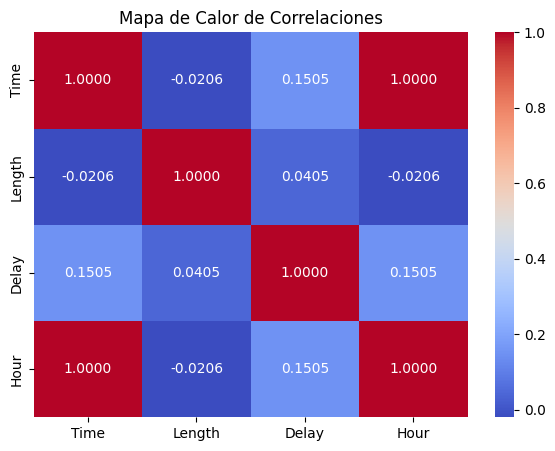

In [ ]:
# MATRIZ DE CORRELACIONES
# -No existen correlaciones significativas
# -Baja correlación entre Delay y Hour
numerico = ['Time', 'Length', 'Delay', 'Hour']
plt.figure(figsize=(7, 5))
sns.heatmap(df[numerico].corr(), annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Mapa de Calor de Correlaciones')
plt.show()

In [ ]:
df_final = df.copy()


In [ ]:
df_final.to_csv("flightontime_df_final.csv", index=False)
print("Exportado:", df_final.shape)

Exportado: (539383, 12)


## 📄Informe final: Análisis de Datos para FlightOnTime

El análisis exploratorio de los datos de vuelos ha revelado varias características clave que son relevantes para el modelado predictivo del retraso de vuelos:

### 1. Estructura y Calidad de los Datos:
*   El dataset original contenía `539,383` registros y `9` columnas.
*   La columna `id` fue eliminada ya que no aportaba información relevante para el análisis o modelado.
*   Se confirmó la ausencia de valores nulos o cadenas vacías después de la limpieza inicial, asegurando la integridad de los datos.

### 2. Variables Numéricas Clave:
*   **`Time` (hora de salida):** Varía de 10 a 1439 minutos (00:10 a 23:59). Esta variable fue utilizada para crear la `Hour` y `TimeDay`.
*   **`Length` (duración del vuelo):** Varía de 0 a 655 minutos. Se identifican registros con Length = 0, los cuales se filtran antes del modelado (Length > 0) para evitar ruido. Esta variable fue utilizada para crear la `Duration`.

### 3. Variables Categóricas Clave:
*   **`Airline`:** Existen `18` aerolíneas únicas. La aerolínea 'WN' (Southwest Airlines) es la más frecuente. Para reducir el impacto de categorías poco frecuentes, se agruparon aerolíneas de baja frecuencia bajo la categoría OTHERS.
*   **`AirportFrom` y `AirportTo`:** Hay `293` aeropuertos de origen y destino únicos, con 'ATL' (Hartsfield-Jackson Atlanta) siendo el más frecuente para ambos.
*   **`DayOfWeek`:** Es una variable numérica que representa el día de la semana. Se observó que los días 5 (viernes) y 6 (sábado) tienen consistentemente menores porcentajes de vuelos retrasados en comparación con otros días.

### 4. Balance de la Variable Objetivo (`Delay`):
*   La variable objetivo `Delay` (retraso) presenta un balance aproximado de `55%` para vuelos sin retraso (0) y `45%` para vuelos con retraso (1).
*   Este balance indica que no hay un desequilibrio severo de clases, aunque es importante evaluar los modelos con métricas más allá de la precisión para asegurar un buen rendimiento en ambas clases.

### 5. Nuevas Variables Creadas:
*   **`DateHour`:** Representación horaria (`HH:MM`) derivada de `Time`, potencialmente útil para capturar patrones horarios de retrasos.
*   **`Hour`:** Hora en formato decimal derivada de `Time`, podría usarse como variable en lugar de esta.
*   **`TimeDay`:** Categorización del momento del día (`Early morning`, `Morning`, `Afternoon`, `Night`) basada en `Time`, que podría capturar diferentes dinámicas de tráfico.
*   **`Duration`:** Categorización de la duración del vuelo (`Short`, `Medium`, `Long`) basada en `Length`, que podría reflejar el impacto de la duración en el retraso.

### Conclusiones para el Modelado:
*   Las variables `Airline`, `AirportFrom`, `AirportTo`, `DayOfWeek`, `Time`, `Length`, `Hour`, `TimeDay` y `Duration` son candidatas clave para la predicción de retrasos.
*   La variable `DayOfWeek` muestra una clara relación con el retraso, lo que la convierte en un predictor valioso.
*   La granularidad de `AirportFrom` y `AirportTo` (293 categorías) sugiere la necesidad de técnicas de codificación que manejen alta cardinalidad, como la codificación por media (Mean Encoding) o One-Hot Encoding con manejo de baja frecuencia, para evitar el problema de la dimensionalidad.
*   El balance de la variable objetivo es favorable, pero la exploración de métricas como `F1-score` y `Recall` será crucial para evaluar el rendimiento del modelo en la identificación de retrasos, más allá de la precisión general.
*   La creación de `Hour`, `TimeDay`, y `Duration` puede capturar patrones temporales y de duración que las variables originales `Time` y `Length` no expresarían directamente a un modelo lineal. Estas variables ya han sido incorporadas en la segunda fase de modelado, junto con la eliminación de `Time` y `Flight` por su menor correlación o alta cardinalidad, respectivamente.

# MODELADO DE DATOS (ML)

### IMPORTAR LIBRERIAS Y DATASET

In [ ]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score

In [ ]:
# -Dataset importado del Análisis
df = pd.read_csv("flightontime_df_final.csv")
print(df.shape)
df.head()

(539383, 12)


,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,DateHour,Hour,TimeDay,Duration
0,CO,269,SFO,IAH,3,15,205,1,1900-01-01 00:15:00,0.250000,Early morning,Long
1,US,1558,PHX,CLT,3,15,222,1,1900-01-01 00:15:00,0.250000,Early morning,Long
2,AA,2400,LAX,DFW,3,20,165,1,1900-01-01 00:20:00,0.333333,Early morning,Medium
3,AA,2466,SFO,DFW,3,20,195,1,1900-01-01 00:20:00,0.333333,Early morning,Long
4,AS,108,ANC,SEA,3,30,202,0,1900-01-01 00:30:00,0.500000,Early morning,Long


## PREPARACIÓN DEL DATAFRAME

In [ ]:
# LIMPIAR DATASET
# -Limpiar vuelos que no tienen duracion por considerarse ruido
df = df[df['Length']>0]

In [ ]:
# SELECCIÓN DE VARIABLES
# -Se escogen las variables categóricas Airline, AirportFrom, AirportTo, DayOfWeek para probar el modelo
# -Se escogen las variables continuas Length y Hour
# -Se escoge la variable Hour como medición del tiempo
eliminar = ['Flight', 'Time', 'DateHour','TimeDay', 'Duration']
df.drop(columns=eliminar, inplace=True)

In [ ]:
# CREACIÓN DE VARIABLES
# -Agrupar aerolineas con una frecuencia relativa menor a 5%, para evitar atomicidad
vc = df['Airline'].value_counts(normalize=True)
cambiar_nombre = vc[vc<0.05].index
df['Airline'] = df['Airline'].replace(cambiar_nombre, 'OTHERS')

df['Airline'].value_counts(normalize=True)*100

,proportion
Airline,
OTHERS,24.212845
WN,17.445433
DL,11.298178
OO,9.317011
AA,8.464549
MQ,6.786508
US,6.396245
XE,5.770710
EV,5.188003


## PREPROCESAMIENTO

In [ ]:
# DEFINIR DATASET
# Obtener una muestra aleatoria
RANDOM_STATE = 42
dfs = df.sample(20000, random_state=RANDOM_STATE)

In [ ]:
# SEPARACION DE DATASET EN TRAIN Y TEST
X = dfs.drop(columns='Delay')
y = dfs['Delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, shuffle=True , stratify=y)

train_temp = X_train.copy()
train_temp['Delay'] = y_train

# TRANSFORMACIÓN DE VARIABLES
# AirportTo, AirportFrom -> Probabilidad de retraso (continua)
# -Mapeo de la media de cada aeropuerto:
from_map = train_temp.groupby('AirportFrom')['Delay'].mean().to_dict()
to_map = train_temp.groupby('AirportTo')['Delay'].mean().to_dict()

# -Mapeo global de la media:
global_mean = y_train.mean()

# -Mapeos aplicados X_train:
X_train['AirportFrom'] = X_train['AirportFrom'].map(from_map).fillna(global_mean).astype(float)
X_train['AirportTo'] = X_train['AirportTo'].map(to_map).fillna(global_mean).astype(float)

# -Mapeos aplicados X_test:
X_test['AirportFrom'] = X_test['AirportFrom'].map(from_map).fillna(global_mean).astype(float)
X_test['AirportTo'] = X_test['AirportTo'].map(to_map).fillna(global_mean).astype(float)

# CODIFICACIÓN DE VARIABLES
# Categoricas -> OnehotEncoder (0,1). Requerido para algoritmos de Machine Learning
# Numericas -> Se utiliza RobustScaler para evitar que el algoritmo sea sensible a valores extremos
cat_cols = ['Airline', 'DayOfWeek']
num_cols = ['Length', 'Hour', 'AirportFrom', 'AirportTo']

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=False
        ), cat_cols),
        ("num", RobustScaler(), num_cols),
    ],
    remainder="drop"
)

# PIPELINES
# -Permiten ejecutar en secuencia la codificacion y entrenamiento del modelo
# -Se definen para los 2 modelos a entrenar: Regresión Logística y Random Forest
pipeline_lr = Pipeline([
    ('pre', preprocess),
    ('model', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=1000, n_jobs=-1))
])

pipeline_rf = Pipeline([
    ('pre', preprocess),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', max_depth=20, n_jobs=-1))
])

## ENTRENAMIENTO DE MODELOS

In [ ]:
# ENTRENAMIENTO DE MODELOS
# Entrenar modelos
pipeline_lr.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

# Predecir en el test set (datos nuevos)
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)

In [ ]:
# EVALUAR RESULTADOS DE LA PREDICCIÓN
# -
print("**************** REGRESIÓN LOGÍSTICA ****************")
print(classification_report(y_test, y_pred_lr))
print("\n******************* RANDOM FOREST *******************")
print(classification_report(y_test, y_pred_rf))

**************** REGRESIÓN LOGÍSTICA ****************
              precision    recall  f1-score   support

           0       0.65      0.64      0.65      2770
           1       0.56      0.57      0.57      2230

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000


******************* RANDOM FOREST *******************
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      2770
           1       0.58      0.52      0.55      2230

    accuracy                           0.62      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.62      0.62      0.62      5000



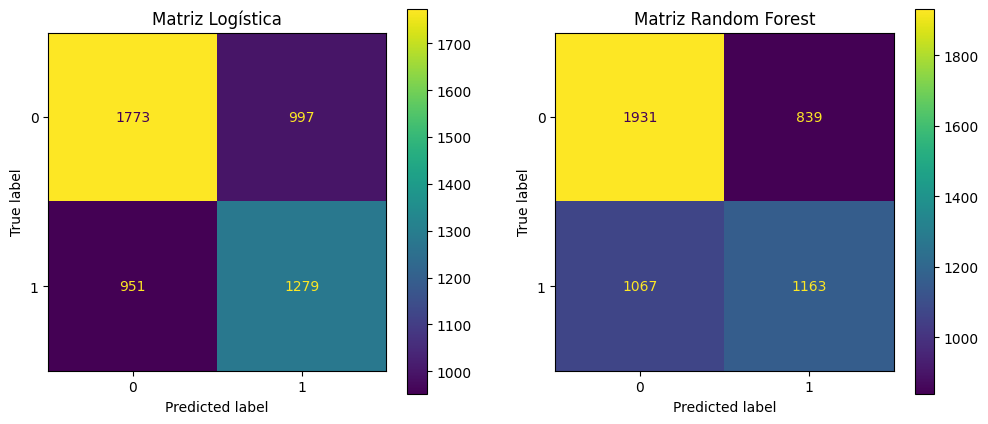

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=ax[0])
ax[0].set_title("Matriz Logística")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax[1])
ax[1].set_title("Matriz Random Forest")

plt.show()

## VALIDACIÓN CRUZADA

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

metrics = ['accuracy', 'precision', 'recall', 'f1']

# --- CROSS VALIDATION PARA LOGÍSTICA ---
cv_results_lr = cross_validate(pipeline_lr, X_train, y_train, cv=skf, scoring=metrics, n_jobs=-1)

# --- CROSS VALIDATION PARA RANDOM FOREST ---
cv_results_rf = cross_validate(pipeline_rf, X_train, y_train, cv=skf, scoring=metrics, n_jobs=-1)

def print_cv_results(name, results):
    print(f"\nResultados CV: {name}")
    print(f"  F1-Score:  {results['test_f1'].mean():.4f} (+/- {results['test_f1'].std():.4f})")
    print(f"  Recall:    {results['test_recall'].mean():.4f}")
    print(f"  Precision: {results['test_precision'].mean():.4f}")
    print(f"  Accuracy:  {results['test_accuracy'].mean():.4f}")

print_cv_results("LOGÍSTICA", cv_results_lr)
print_cv_results("RANDOM FOREST", cv_results_rf)


Resultados CV: LOGÍSTICA
  F1-Score:  0.5947 (+/- 0.0141)
  Recall:    0.5974
  Precision: 0.5921
  Accuracy:  0.6369

Resultados CV: RANDOM FOREST
  F1-Score:  0.5505 (+/- 0.0062)
  Recall:    0.5147
  Precision: 0.5918
  Accuracy:  0.6251


## OPTIMIZACIÓN DE HIPERPARAMETROS

In [ ]:
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20],
    'model__min_samples_split': [2, 5, 8],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt']
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

grid_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=skf,
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_train, y_train)

print("Mejores parámetros:")
print(grid_rf.best_params_)

print(f"\nMejor F1 (CV): {grid_rf.best_score_:.4f}")

best_model = grid_rf.best_estimator_

y_pred = best_model.predict(X_test)

print("\nReporte de clasificación (TEST):")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mejores parámetros:
{'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 8, 'model__n_estimators': 100}

Mejor F1 (CV): 0.5939

Reporte de clasificación (TEST):
              precision    recall  f1-score   support

           0       0.65      0.67      0.66      2770
           1       0.57      0.55      0.56      2230

    accuracy                           0.62      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.62      0.62      0.62      5000



### CALIBRACIÓN DEL MODELADO (para microservicios)

In [ ]:
# from sklearn.calibration import CalibratedClassifierCV

# calibrated_model = CalibratedClassifierCV(
#     best_model,
#     method="isotonic",  # o "sigmoid"
#     cv=5
# )

# calibrated_model.fit(X_train, y_train)


## OPTIMIZACIÓN DE TRESHOLD

In [ ]:
# Modelo sin calibrar
probs_train = best_model.predict_proba(X_train)[:, 1]

# Modelo calibrado
# Debiera mejorar:
# la interpretación de probabilidades
# la estabilidad del threshold
#probs_train = calibrated_model.predict_proba(X_train)[:, 1]

thresholds = np.linspace(0.1, 0.9, 50)
best_f1 = 0
best_thr = 0.5

for t in thresholds:
    score = f1_score(y_train, (probs_train >= t).astype(int))
    if score > best_f1:
        best_f1 = score
        best_thr = t

print(f"Mejor umbral: {best_thr:.4f}  |  F1: {best_f1:.4f}")

Mejor umbral: 0.4429  |  F1: 0.7121


In [ ]:
# Evaluación final
probs_test = best_model.predict_proba(X_test)[:, 1]
y_pred_opt = (probs_test >= best_thr).astype(int)

print("\nReporte de clasificación con threshold optimizado:")
print(classification_report(y_test, y_pred_opt))


Reporte de clasificación con threshold optimizado:
              precision    recall  f1-score   support

           0       0.69      0.49      0.58      2770
           1       0.54      0.72      0.61      2230

    accuracy                           0.60      5000
   macro avg       0.61      0.61      0.60      5000
weighted avg       0.62      0.60      0.59      5000



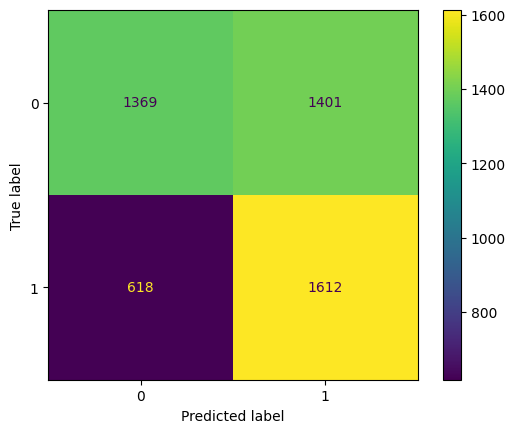

In [ ]:
# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt)

### FEATURE IMPORTANCE

In [ ]:
# IMPORTANCIA DE LAS VARIABLES
# -Variables que más influyen en el modelo en %
importances = best_model._final_estimator.feature_importances_
features = preprocess.get_feature_names_out()

feat_importances = pd.DataFrame({'Feature': features, 'Importance':(importances*100).round(2)}) \
                     .sort_values('Importance', ascending=False) \
                     .reset_index(drop=True)
feat_importances

,Feature,Importance
0,num__Hour,22.33
1,num__AirportFrom,19.43
2,num__AirportTo,18.44
3,cat__Airline_WN,14.39
4,num__Length,11.79
5,cat__Airline_UA,1.59
6,cat__Airline_OTHERS,1.45
7,cat__DayOfWeek_5,0.93
8,cat__DayOfWeek_3,0.92
9,cat__DayOfWeek_6,0.92


## EXPORTACIÓN

In [ ]:
!pip install skl2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 61.3 MB/s eta 0:00:00


In [ ]:
import json
from skl2onnx import convert_sklearn, __max_supported_opset__
from skl2onnx.common.data_types import FloatTensorType, StringTensorType, Int64TensorType

initial_type = [
    ('Airline', StringTensorType([None, 1])),
    ('AirportFrom', FloatTensorType([None, 1])),
    ('AirportTo', FloatTensorType([None, 1])),
    ('DayOfWeek', Int64TensorType([None, 1])),
    ('Length', FloatTensorType([None, 1])),
    ('Hour', FloatTensorType([None, 1]))
]

# 🔑 Esto (options) hace que ONNX entregue: (para microservicios)
# output[0] → labels
# output[1] → probabilidades reales
# options = {
#     id(best_model): {
#         "zipmap": False,
#         "output_class_labels": True
#     }
# }

onx = convert_sklearn(
    best_model,
    initial_types=initial_type,
    # options=options,
    target_opset=__max_supported_opset__
)

onnx_path = "flight_delay_model.onnx"
with open(onnx_path, "wb") as f:
    f.write(onx.SerializeToString())
print(f"Modelo exportado: {onnx_path}")

threshold_path = "flight_delay_threshold.json"
threshold_info = {"best_threshold": best_thr}

with open(threshold_path, "w") as f:
    json.dump(threshold_info, f)

print(f"Threshold guardado: {threshold_path}  |  Valor: {best_thr:.4f}")

mappings = {
    "from_map": from_map,
    "to_map": to_map,
    "global_mean": float(global_mean)
}

with open("airport_mappings.json", "w") as f:
    json.dump(mappings, f)

Modelo exportado: flight_delay_model.onnx
Threshold guardado: flight_delay_threshold.json  |  Valor: 0.4429


In [ ]:
# EXPORTAR FEATURE IMPORTANCES
feat_importances_dict = dict(zip(feat_importances['Feature'], feat_importances['Importance']))

with open("airport_feat_importances.json", "w") as f:
    json.dump(feat_importances_dict, f)

In [ ]:
# EXPORTAR PROMEDIO DE AIRPORTS (AirportFrom - AirportTo)
df2[['AirportFrom', 'AirportTo', 'LengthAvg']].to_json(path_or_buf='airports_length_avg.json', orient='records')

```
from skl2onnx import InferenceSession
session = InferenceSession(onnx_path)
  with open(threshold_path) as f:
   threshold = json.load(f)['best_threshold']

X_input debe ser un diccionario tipo {columna: np.array([...])}
probs = session.run(None, X_input)[1][:,1]  # columna de probabilidad de clase 1
y_pred = (probs >= threshold).astype(int)
print("Predicciones finales con threshold aplicado:", y_pred)
```
> Ejemplo de inferencia

# 📄 Informe final: Modelado Predictivo para FlightOnTime

Este informe documenta el proceso de modelado predictivo para la detección de retrasos en vuelos, desde la preparación de los datos hasta la selección y exportación del modelo final.

## 1) Objetivo del modelado
- Construir un modelo de **clasificación binaria** para predecir si un vuelo será **Puntual (Delay=0)** o **Retrasado (Delay=1)**, devolviendo además una **probabilidad** para habilitar decisiones por umbral (threshold) e integración con un microservicio/API.

## 2) Datos de entrada y preparación
- Se carga el dataset exportado desde el análisis: **`flightontime_df_final.csv`**.
- **Limpieza / filtrado:** se eliminan registros con `Length = 0` (se filtra `Length > 0`) por considerarse ruido.
- **Eliminación de columnas no usadas en el MVP:** se eliminan `Flight`, `Time`, `DateHour`, `TimeDay`, `Duration` para dejar un set de variables más generalizable y coherente con el enfoque del MVP.
- **Agrupación de aerolíneas poco frecuentes:** se reemplazan aerolíneas con frecuencia relativa menor a 5% por la categoría **`OTHERS`** para reducir fragmentación.

## 3) Definición de dataset para entrenamiento
- Se toma una muestra aleatoria de **20,000** registros para iteración rápida (`random_state=42`).
- Se separan features y target:
  - `X = dfs.drop('Delay')`
  - `y = dfs['Delay']`
- Se realiza partición **train/test** con `test_size=0.25`, `shuffle=True` y `stratify=y` para mantener proporciones de clases.

## 4) Transformación de variables (alta cardinalidad)
- Para manejar la alta cardinalidad de **`AirportFrom`** y **`AirportTo`**, se aplica una transformación tipo **mean/target encoding**:
  - Se calcula la media de `Delay` por aeropuerto **solo en train** (`from_map`, `to_map`).
  - Se define una media global (`global_mean`) como fallback.
  - Aeropuertos no vistos se imputan con `global_mean`.

> Esto reduce dimensionalidad y mantiene una representación numérica útil para modelos clásicos.

## 5) Preprocesamiento y pipelines
Se usa un `ColumnTransformer` dentro de pipelines, combinando:
- **OneHotEncoder** para variables categóricas (por ejemplo `Airline`, `DayOfWeek`) con manejo de desconocidos.
- **RobustScaler** para variables numéricas (por ejemplo `Length`, `Hour` y los aeropuertos ya transformados a continuo).
- Se configuran dos pipelines de entrenamiento:
  - **Regresión Logística** como baseline (`class_weight='balanced'`, `max_iter=1000`).
  - **Random Forest** como modelo no lineal (`class_weight='balanced'`, `max_depth=20`).

## 6) Entrenamiento y evaluación inicial
- Se entrenan ambos modelos con `X_train, y_train`.
- Se evalúan sobre test con `classification_report` para comparar desempeño (accuracy, precision, recall, f1) entre:
  - Regresión logística
  - Random Forest

## 7) Validación cruzada y selección de enfoque
- Se ejecuta **validación cruzada** con `StratifiedKFold` y métricas: `accuracy`, `precision`, `recall`, `f1` para estimar rendimiento promedio y estabilidad.

## 8) Optimización de hiperparámetros (Random Forest)
- Se realiza **GridSearchCV** sobre Random Forest (optimizando `f1`) explorando parámetros como:
  - `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features='sqrt'`.
- Se selecciona `best_model` como el estimador con mejor F1 en CV y se evalúa nuevamente en test.

## 9) Optimización de threshold (decisión final)
- Se calcula `predict_proba` y se busca el **mejor umbral** en el rango `0.1–0.9` para **maximizar F1**.
- Se evalúa el modelo final aplicando ese threshold:
  - `y_pred_opt = (probs_test >= best_thr).astype(int)`
- Se reporta `classification_report` y matriz de confusión para la predicción final con threshold optimizado.

## 10) Interpretabilidad
- Se calculan y visualizan **feature importances** del Random Forest utilizando nombres reales del preprocesamiento (`get_feature_names_out()`).
- Estas importancias se exportan para uso en la API/README (explicabilidad básica del MVP).

## 11) Exportación para integración (microservicios/API)
El notebook deja artefactos listos para despliegue:
- **Modelo ONNX** (exportado con `skl2onnx`) con tipos de entrada esperados:
  - `Airline` (string)
  - `DayOfWeek` (int64)
  - `Length`, `Hour`, `AirportFrom`, `AirportTo` (float)
- **Threshold optimizado** guardado en `flight_delay_threshold.json` (`best_threshold`).
- **Mapeos de aeropuertos** guardados en `airport_mappings.json`:
  - `from_map`, `to_map`, `global_mean` para transformar IATA → continuo antes de inferencia.
- **Feature importances** guardadas en `airport_feat_importances.json`.
- Se exporta un archivo adicional `airports_length_avg.json` con promedios relacionados a aeropuertos/ruta (según el dataframe generado en el notebook).

Además, se incluye un ejemplo de inferencia ONNX aplicando el threshold para obtener la predicción final.

## Conclusión
El pipeline desarrollado cumple con el objetivo del MVP: a partir de información operativa disponible antes del despegue, se construyó una solución reproducible que devuelve **predicción (Puntual/Retrasado) + probabilidad**, con un **umbral optimizado** para mejorar el desempeño en métricas relevantes (especialmente **F1/Recall**).  

La estrategia de preprocesamiento (agrupación de aerolíneas poco frecuentes, escalado robusto y tratamiento de alta cardinalidad en aeropuertos mediante encoding estadístico) permite entrenar modelos clásicos de forma eficiente y con buena capacidad de generalización dentro del alcance del hackathon. Además, la exportación de artefactos (**ONNX + threshold + mappings + feature importances**) deja el sistema listo para integración en una API y para explicar de manera básica las decisiones del modelo.

Como siguiente paso, para fortalecer la validez del proceso y la confiabilidad de las probabilidades en producción, se recomienda **encapsular el encoding de aeropuertos dentro del pipeline** (evitando leakage en CV) y evaluar **calibración de probabilidades** si el producto requiere decisiones más sensibles al riesgo.

